# Step 1 - Model Training

Now that we have a feel for the data we are dealing with, we can start designing our model. In this notebook, we will define the network architecture and train the model. We will also discuss some of the transformations on the data in response to observations that we made in the data exploration section of the notebook.

Let us start by importing some libraries and defining some paths.

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image

from keras_tqdm import TQDMNotebookCallback

import json
import os
import numpy as np
import pandas as pd
from Generator import DriveDataGenerator
from Cooking import checkAndCreateDir
import h5py
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt


BASE_PATH = 'D:\GTA_DATA1'

# << Point this to the desired output directory for the cooked (.h5) data >>
COOKED_DATA_DIR = os.path.join(BASE_PATH, 'data_cooked')

# << The directory in which the model output will be placed >>
MODEL_OUTPUT_DIR = os.path.join(BASE_PATH, 'model_GTA_holein1')
print(MODEL_OUTPUT_DIR)

D:\GTA_DATA1\model_GTA_holein1


Let's read in the datasets from the exploration phase. If these do not exist, run the snippet from the [previous](DataExplorationAndPreparation.ipynb) notebook to generate them.

In [3]:
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')

num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]

batch_size=32

For image data, it is too expensive to load the entire dataset into memory. Fortunatly, Keras has the concept of DataGenerators. A DataGenerator is nothing more than an iterator that will read data from disk in chunks. This allows you to keep both your CPU and GPU busy, increasing throughput. 

We made a few observations during the exploration phase. Now let's come up with a strategy to incorporate them in our training algorithm:
* **Only a small portion of the image is of interest** - when generating batches, we can remove the pieces of the image that are not of interest.
* **The dataset exhibits vertical flip tolerance** - when generating batches, we can randomly flip some images and labels around the Y axis so the model has new data to learn from.
* **The dataset should be invariant to changes in lighting** - when generating batches, we can randomly add or remove brightness from the images so the model can learn that global changes in lighting should be ignored.
* **The dataset has a high proportion of zero-valued images** - when generating batches, we can randomly drop a percentage of data points where the steering angle is zero so the model sees a balanced dataset when training.
* **We need examples from the swerving strategy in our dataset so the model learns how to turn sharply** - we took care of this in the preprocessing phase.

While Keras does have some standard built-in transforms for images, they are not sufficient for our purpose. For example, when using horizontal_flip = True in the standard ImageDataGenerator, the signs of the labels are not inverted. Fortunatly, we can just extend the ImageDataGenerator class and implement our own transform logic. The code to do so is in Generator.py - it is straightforward, but too long to include in this notebook.

Here, we will initialize the generator with the following parameters:
* **Zero_Drop_Percentage: 0.9** - That is, we will randomly drop 90% of the data points with label = 0
* **Brighten_Range: 0.4** - That is, the brighness of each image will be modified by up to 40%. To compute "brightness", we transform the image from RGB to HSV space, scale the 'V' coordinate up or down, and transform back to RGB space.
* **ROI: [76,135,0,255]** - This is the x1, x2, y1, y2 rectangle that represents the area of interest for the images.

> **Thought Exercise 1.1**
Try playing around with these parameters to see if you can get better results.

In [8]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brighten_range=0.4)
# 800,600
# train_generator = data_generator.flow\
#     (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.90, roi=[350,590,0,795])
# eval_generator = data_generator.flow\
#     (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.90, roi=[350,590,0,795])

#200, 150
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.90, roi=[80,148,2,198])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.90, roi=[80,148,2,198])

Let's look at a sample batch. The steering angle is represented by the red line in the image:

Actual Steering Value = [-2300.]


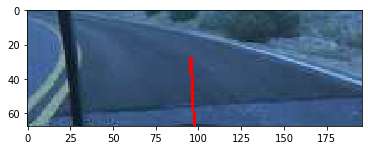

Actual Steering Value = [-666.66666667]


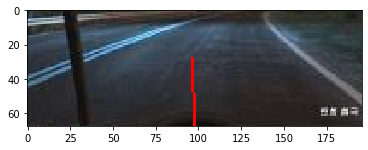

Actual Steering Value = [2333.33333333]


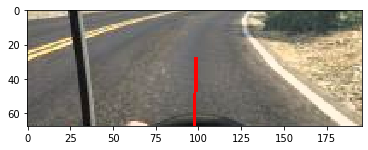

Actual Steering Value = [3700.]


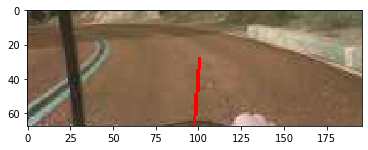

Actual Steering Value = [200.]


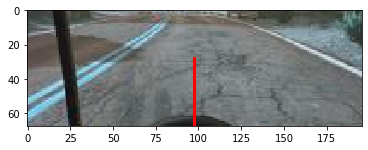

Actual Steering Value = [2500.]


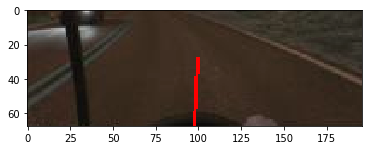

Actual Steering Value = [-100.]


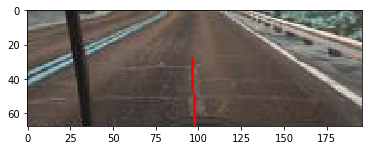

Actual Steering Value = [-100.]


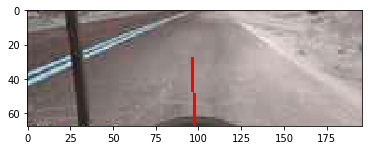

Actual Steering Value = [-4766.66666667]


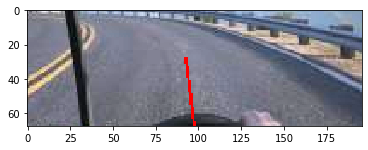

Actual Steering Value = [-933.33333333]


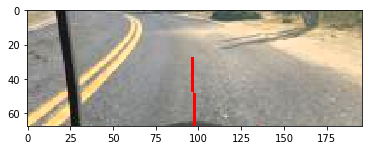

In [17]:
def draw_image_with_label(img, label, prediction=None):
#     theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
    theta = label * 0.69 / 32700 
#     theta = label
    line_length = 40
    line_thickness = 2
    label_line_color = (255, 0, 0) #red
    prediction_line_color = (0, 0, 255) #blue
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Value = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69 / 32700
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()

[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 10, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i])

Next, let's define the network architecture. We will use a standard combination of convolutional / max pooling layers to process the images (we cannot go into the details of what each of these layers do here, but you should definitely check out the book mentioned in the readme file if you do not understand what is going on). Then, we will inject the vehicle's last known state into the dense layer as an additional feature. The layer sizes and optimization parameters were determined experimentally - try tweaking them and see what happens!

In [18]:
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Let's look at a summary of our model

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 68, 196, 3)   0                                            
__________________________________________________________________________________________________
convolution0 (Conv2D)           (None, 68, 196, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 34, 98, 16)   0           convolution0[0][0]               
__________________________________________________________________________________________________
convolution1 (Conv2D)           (None, 34, 98, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

That's a lot of parameters! Fortunately, we have our data augmentation strategies, so the network has a chance of converging. Try adding / removing layers or changing their widths to see what effect it has on the number of trainable parameters in the network.

One of the nice features of Keras is the ability to declare callbacks. These functions get executed after each epoch of training. We will define a few callbacks:

* **ReduceLrOnPlateau** - If the model is near a minimum and the learning rate is too high, then the model will circle around that minimum without ever reaching it. This callback will allow us to reduce the learning rate when the validation loss stops improving, allowing us to reach the optimal point.
* **CsvLogger** - This lets us log the output of the model after each epoch, which will allow us to track the progress without needing to use the console.
* **ModelCheckpoint** - Generally, we will want to use the model that has the lowest loss on the validation set. This callback will save the model each time the validation loss improves.
* **EarlyStopping** - We will want to stop training when the validation loss stops improving. Otherwise, we risk overfitting. This monitor will detect when the validation loss stops improving, and will stop the training process when that occurs.

In [20]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, TQDMNotebookCallback()]

It's time to train the model! With the default setup, this model takes ~45 min to train on an NVidia GTX970 GPU. Note: sometimes the model will get stuck with a constant validation loss for up to 7 epochs. If left to run, the model should terminate with a validation loss of approximately .0003.

In [21]:
history = model.fit_generator(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=1000, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

Epoch 1/1000
Epoch 00001: val_loss improved from inf to 1957267.71230, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.01-1957267.7123025.h5
 - 28s - loss: 3972249.3510 - val_loss: 1957267.7123


Epoch 2/1000
Epoch 00002: val_loss improved from 1957267.71230 to 707548.27087, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.02-707548.2708721.h5
 - 21s - loss: 1670981.7026 - val_loss: 707548.2709


Epoch 3/1000
Epoch 00003: val_loss improved from 707548.27087 to 427244.88200, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.03-427244.8820001.h5
 - 22s - loss: 999299.2360 - val_loss: 427244.8820


Epoch 4/1000
Epoch 00004: val_loss improved from 427244.88200 to 237355.80362, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.04-237355.8036234.h5
 - 22s - loss: 732378.7005 - val_loss: 237355.8036


Epoch 5/1000
Epoch 00005: val_loss improved from 237355.80362 to 133450.57245, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.05-133450.5724489.h5
 - 21s - loss: 565598.3474 - val_loss: 133450.5724


Epoch 6/1000
Epoch 00006: val_loss improved from 133450.57245 to 81951.64643, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.06-81951.6464276.h5
 - 21s - loss: 525682.9318 - val_loss: 81951.6464


Epoch 7/1000
Epoch 00007: val_loss improved from 81951.64643 to 62506.97548, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.07-62506.9754791.h5
 - 21s - loss: 484768.4584 - val_loss: 62506.9755


Epoch 8/1000
Epoch 00008: val_loss improved from 62506.97548 to 52179.96826, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.08-52179.9682553.h5
 - 21s - loss: 450204.6753 - val_loss: 52179.9683


Epoch 9/1000
Epoch 00009: val_loss improved from 52179.96826 to 39424.94293, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.09-39424.9429265.h5
 - 21s - loss: 431576.9971 - val_loss: 39424.9429


Epoch 10/1000
Epoch 00010: val_loss did not improve
 - 22s - loss: 378281.5276 - val_loss: 44840.1687


Epoch 11/1000
Epoch 00011: val_loss did not improve
 - 21s - loss: 397478.0989 - val_loss: 42183.9014


Epoch 12/1000
Epoch 00012: val_loss improved from 39424.94293 to 36122.22966, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.12-36122.2296620.h5
 - 21s - loss: 378152.2304 - val_loss: 36122.2297


Epoch 13/1000
Epoch 00013: val_loss did not improve
 - 23s - loss: 371502.5057 - val_loss: 37283.7416


Epoch 14/1000
Epoch 00014: val_loss improved from 36122.22966 to 30883.81458, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.14-30883.8145820.h5
 - 22s - loss: 381449.5276 - val_loss: 30883.8146


Epoch 15/1000
Epoch 00015: val_loss did not improve
 - 22s - loss: 385067.9029 - val_loss: 35204.9842


Epoch 16/1000
Epoch 00016: val_loss did not improve
 - 21s - loss: 385894.3526 - val_loss: 40874.0223


Epoch 17/1000
Epoch 00017: val_loss did not improve
 - 21s - loss: 385592.6227 - val_loss: 31427.7988


Epoch 18/1000
Epoch 00018: val_loss did not improve
 - 21s - loss: 368869.3177 - val_loss: 41506.6337


Epoch 19/1000
Epoch 00019: val_loss improved from 30883.81458 to 28085.68716, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.19-28085.6871612.h5
 - 21s - loss: 373414.0664 - val_loss: 28085.6872


Epoch 20/1000
Epoch 00020: val_loss did not improve
 - 21s - loss: 370684.3798 - val_loss: 38521.1841


Epoch 21/1000
Epoch 00021: val_loss did not improve
 - 22s - loss: 376255.8073 - val_loss: 36816.8412


Epoch 22/1000
Epoch 00022: val_loss improved from 28085.68716 to 23794.78918, saving model to D:\GTA_DATA1\model_GTA_holein1\models\model_model.22-23794.7891762.h5
 - 21s - loss: 362047.3883 - val_loss: 23794.7892


Epoch 23/1000
Epoch 00023: val_loss did not improve
 - 22s - loss: 356716.7037 - val_loss: 40158.7616


Epoch 24/1000
Epoch 00024: val_loss did not improve
 - 21s - loss: 368467.7404 - val_loss: 49828.9573


Epoch 25/1000
Epoch 00025: val_loss did not improve
 - 21s - loss: 355069.4871 - val_loss: 40069.2490


Epoch 26/1000
Epoch 00026: val_loss did not improve
 - 22s - loss: 354859.1951 - val_loss: 31761.9710


Epoch 27/1000
Epoch 00027: val_loss did not improve
 - 22s - loss: 341138.7504 - val_loss: 28202.1760


Epoch 28/1000
Epoch 00028: val_loss did not improve
 - 21s - loss: 356059.7684 - val_loss: 41362.1430


Epoch 29/1000
Epoch 00029: val_loss did not improve
 - 22s - loss: 375650.2869 - val_loss: 45008.6956


Epoch 30/1000
Epoch 00030: val_loss did not improve
 - 21s - loss: 355923.6992 - val_loss: 45250.7484


Epoch 31/1000
Epoch 00031: val_loss did not improve
 - 21s - loss: 372004.8281 - val_loss: 31074.2689


Epoch 32/1000
Epoch 00032: val_loss did not improve
 - 22s - loss: 351065.2424 - val_loss: 37967.9936
Epoch 00032: early stopping



Let's do a quick sanity check. We'll load a few training images and compare the labels and the predictions. These should be very close in value if our model has learned properly.

Actual Steering Value = [2500.]
Predicted Steering Angle = [2334.7698]
L1 Error: [165.23022461]


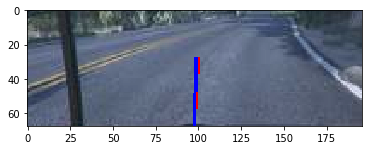

Actual Steering Value = [-900.]
Predicted Steering Angle = [-835.6864]
L1 Error: [64.31359863]


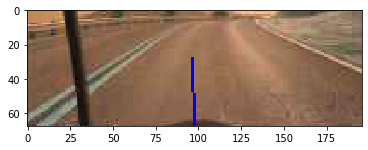

Actual Steering Value = [2333.33333333]
Predicted Steering Angle = [2149.1387]
L1 Error: [184.19466146]


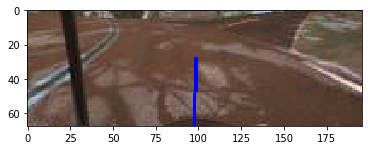

Actual Steering Value = [4700.]
Predicted Steering Angle = [4190.017]
L1 Error: [509.98291016]


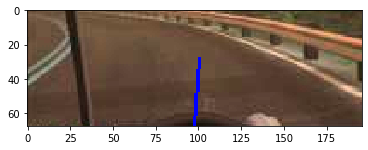

Actual Steering Value = [5400.]
Predicted Steering Angle = [5296.669]
L1 Error: [103.33105469]


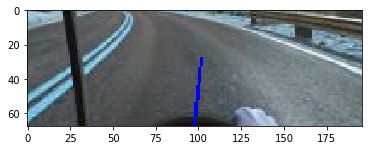

Actual Steering Value = [66.66666667]
Predicted Steering Angle = [-101.741936]
L1 Error: [168.4086024]


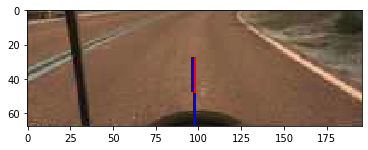

Actual Steering Value = [100.]
Predicted Steering Angle = [76.58922]
L1 Error: [23.41078186]


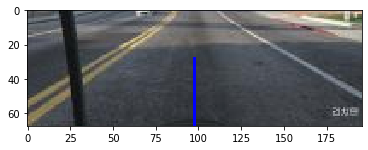

Actual Steering Value = [-5133.33333333]
Predicted Steering Angle = [-4683.541]
L1 Error: [449.79231771]


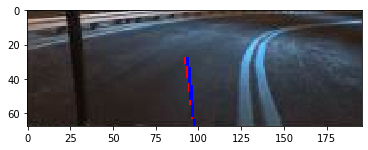

Actual Steering Value = [1366.66666667]
Predicted Steering Angle = [1319.0111]
L1 Error: [47.65555827]


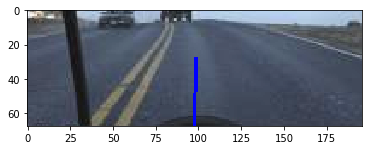

Actual Steering Value = [900.]
Predicted Steering Angle = [851.464]
L1 Error: [48.53601074]


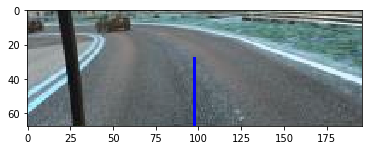

In [22]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(0, 10, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])

Looks good! Let's move on to actually running the model with AirSim in the [next notebook](TestModel.ipynb).